# 코로나 이후 매출 증감여부 예측 모델

#### #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

#### #02. 데이터셋 준비하기

In [2]:
origin = read_excel("tdf.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   상권_코드        1009 non-null   int64  
 1   상권_코드_명      1009 non-null   object 
 2   점포수_x        1009 non-null   float64
 3   도심_x         1009 non-null   int64  
 4   총_직장_인구_수_x  1009 non-null   float64
 5   총_생활인구_수_x   1009 non-null   float64
 6   점포수_y        1009 non-null   float64
 7   총_직장_인구_수_y  1009 non-null   int64  
 8   총_생활인구_수_y   1009 non-null   float64
 9   매출증감         1009 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 79.0+ KB


#### #03. 데이터 전처리 

결측치 확인

In [3]:
origin.isna().sum()

상권_코드          0
상권_코드_명        0
점포수_x          0
도심_x           0
총_직장_인구_수_x    0
총_생활인구_수_x     0
점포수_y          0
총_직장_인구_수_y    0
총_생활인구_수_y     0
매출증감           0
dtype: int64

#### #04. 탐색적 데이터 분석

> ###### 앞 과정에서 이미 수행하였으므로 생략

#### #05. 데이터셋 분할하기

랜덤시드 고정

In [4]:
np.random.seed(777)

훈련 데이터(독랍변수)와 레이블(종속변수) 구분하기

In [5]:
x = origin.drop(['상권_코드','상권_코드_명','매출증감'], axis=1)
x.head()

,점포수_x,도심_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,6.825688,1,21133.770642,9.668614e+05,6.564356,13700,1.108208e+06
1,4.519231,1,10343.230769,3.061709e+06,4.493333,11773,3.704169e+06
2,7.094340,1,43510.654088,2.080373e+06,7.382550,39506,1.775981e+06
3,4.418182,1,8267.454545,2.114242e+06,4.390000,1696,3.109088e+06
4,3.263158,1,2711.131579,2.506074e+05,3.417910,4252,4.745286e+05


In [6]:
y = origin['매출증감']
y

0       0
1       0
2       0
3       0
4       0
       ..
1004    0
1005    1
1006    0
1007    0
1008    1
Name: 매출증감, Length: 1009, dtype: int64

데이터 표준화

명목형을 제거한 임시 데이터프레임을 생성

In [7]:
tmp = x.drop('도심_x', axis=1)
tmp

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,6.825688,21133.770642,9.668614e+05,6.564356,13700,1.108208e+06
1,4.519231,10343.230769,3.061709e+06,4.493333,11773,3.704169e+06
2,7.094340,43510.654088,2.080373e+06,7.382550,39506,1.775981e+06
3,4.418182,8267.454545,2.114242e+06,4.390000,1696,3.109088e+06
4,3.263158,2711.131579,2.506074e+05,3.417910,4252,4.745286e+05
...,...,...,...,...,...,...
1004,3.347826,1999.320652,3.245324e+06,3.603659,2122,5.776149e+06
1005,4.018072,4313.216867,5.847782e+05,4.311765,966,1.371762e+06
1006,5.335484,4582.309677,5.188177e+06,5.780303,2503,7.212605e+06
1007,4.771084,5432.831325,5.725559e+06,4.650685,6064,8.757489e+06


임시 데이터프레임을 활용하여 표준화

In [8]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(tmp)
x_scale_df = DataFrame(x_scale, columns=tmp.columns, index=tmp.index)
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,1.466482,1.423805,-1.545368,1.082146,0.790915,-1.809769
1,0.114631,0.317615,0.057226,-0.064296,0.578999,-0.461570
2,1.623943,3.717765,-0.693512,1.535069,3.628849,-1.462965
3,0.055405,0.104818,-0.667602,-0.121498,-0.529187,-0.770622
4,-0.621573,-0.464787,-2.093314,-0.659611,-0.248099,-2.138868
...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.197695,-0.556788,-0.482339,0.614503
1005,-0.179106,-0.300550,-1.837668,-0.164806,-0.609466,-1.672894
1006,0.593050,-0.272964,1.684010,0.648123,-0.440440,1.360518
1007,0.262246,-0.185773,2.095117,0.022808,-0.048830,2.162846


표준화 결과에 명목형 변수를 결합

In [9]:
x_scale_df['도심'] = x['도심_x']
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y,도심
0,1.466482,1.423805,-1.545368,1.082146,0.790915,-1.809769,1
1,0.114631,0.317615,0.057226,-0.064296,0.578999,-0.461570,1
2,1.623943,3.717765,-0.693512,1.535069,3.628849,-1.462965,1
3,0.055405,0.104818,-0.667602,-0.121498,-0.529187,-0.770622,1
4,-0.621573,-0.464787,-2.093314,-0.659611,-0.248099,-2.138868,1
...,...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.197695,-0.556788,-0.482339,0.614503,0
1005,-0.179106,-0.300550,-1.837668,-0.164806,-0.609466,-1.672894,0
1006,0.593050,-0.272964,1.684010,0.648123,-0.440440,1.360518,0
1007,0.262246,-0.185773,2.095117,0.022808,-0.048830,2.162846,0


훈련데이터와 검증 데이터로 분할

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_scale_df, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((706, 7), (303, 7), (706,), (303,))

#### #06. 모델 개발

모델 정의

In [11]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(7, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


학습하기

In [12]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
23/23 [==============================] - 1s 8ms/step - loss: 0.6992 - acc: 0.5000 - val_loss: 0.6961 - val_acc: 0.5215 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 0s 3ms/step - loss: 0.6879 - acc: 0.5467 - val_loss: 0.6904 - val_acc: 0.5281 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 0s 3ms/step - loss: 0.6829 - acc: 0.5793 - val_loss: 0.6899 - val_acc: 0.5479 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6804 - acc: 0.5907 - val_loss: 0.6900 - val_acc: 0.5446 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 0s 3ms/step - loss: 0.6792 - acc: 0.5892 - val_loss: 0.6886 - val_acc: 0.5512 - lr: 0.0010
Epoch 6/500
23/23 [==============================] - 0s 3ms/step - loss: 0.6778 - acc: 0.5822 - val_loss: 0.6867 - val_acc: 0.5677 - lr: 0.0010
Epoch 7/500
23/23 [==============================] - 0s 3ms/step - loss: 0.6762 - acc: 0.5807 - val_loss: 0.6887 - val_acc: 0.5578 - lr:

#### #07. 학습결과 평가

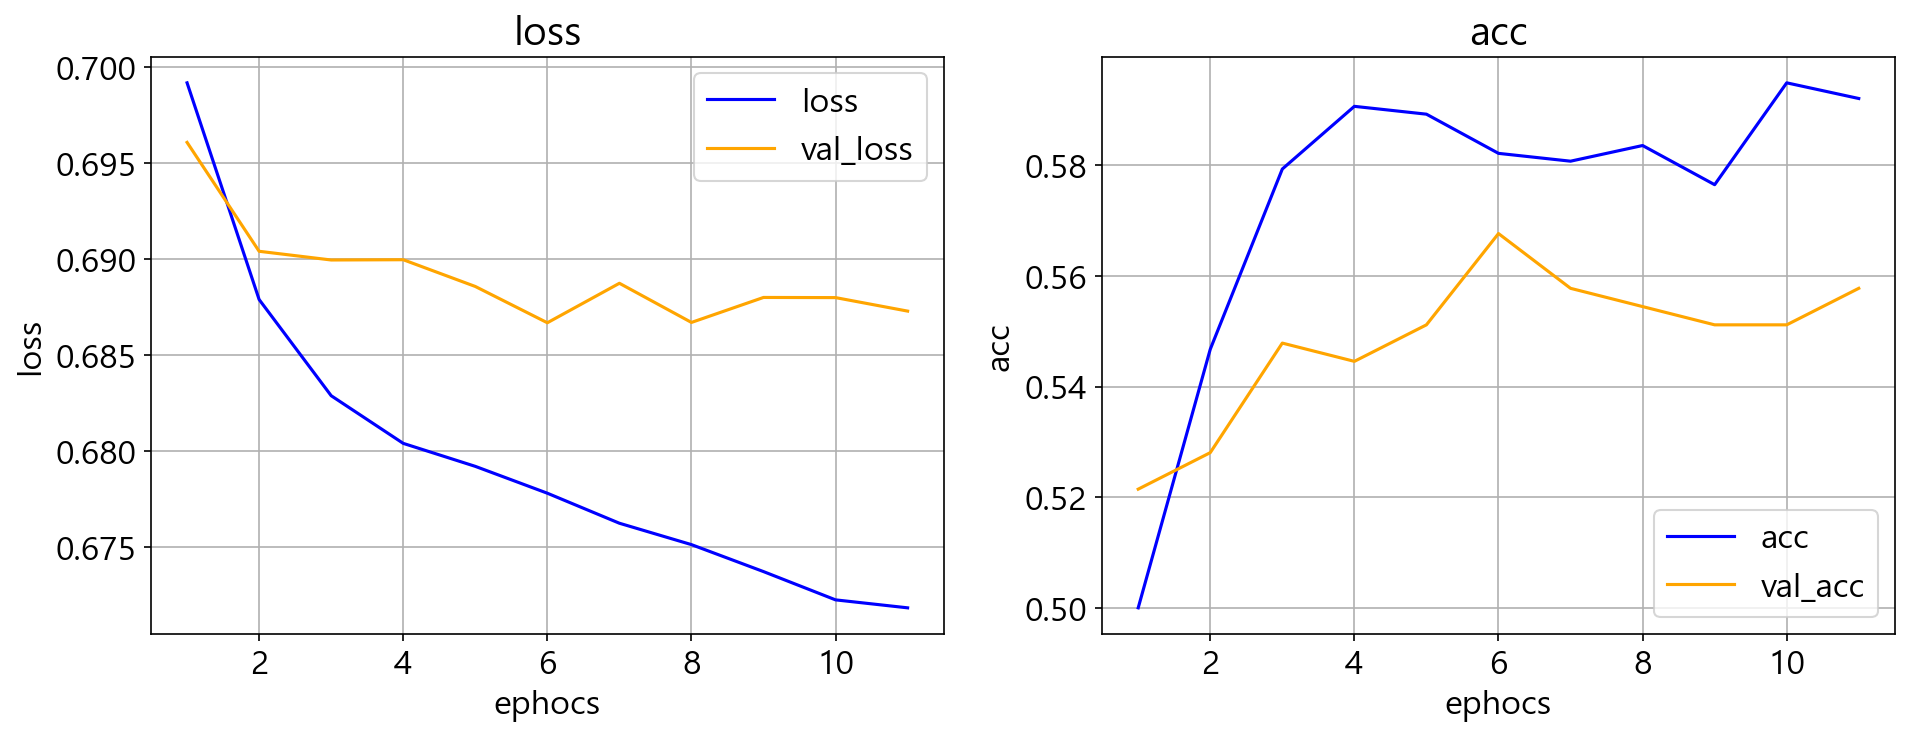

23/23 [==============================] - 0s 1ms/step - loss: 0.6702 - acc: 0.6006
최종 훈련 손실률: 0.670229, 최종 훈련 정확도: 0.600567
10/10 [==============================] - 0s 1000us/step - loss: 0.6873 - acc: 0.5578
최종 검증 손실률: 0.687279, 최종 검증 정확도: 0.557756


In [13]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

In [14]:
logit_result = helper.tf_logit_result(model, result, x_train, y_train)

23/23 [==============================] - 0s 864us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
logit_result.cmdf

,Negative,Positive
True,367,257
False,25,57


In [16]:
helper.prettyPrint(logit_result.result_df.T)

+--------------------------+-----------+
|                          |         0 |
|--------------------------+-----------|
| 정확도(Accuracy)         |  0.600567 |
| 정밀도(Precision)        |  0.695122 |
| 재현율(Recall, TPR)      |  0.181529 |
| 위양성율(Fallout, FPR)   | 0.0637755 |
| 특이성(Specificity, TNR) |  0.936224 |
| RAS                      |  0.558877 |
| f1_score                 |  0.287879 |
+--------------------------+-----------+
